In [ ]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd
df2 = pd.read_csv(io.BytesIO(uploaded['train.csv']))

uploaded =files.upload()
df3 = pd.read_csv(io.BytesIO(uploaded['test.csv']))

# Dataset is now stored in a Pandas Dataframe

Saving train.csv to train (1).csv


Saving test.csv to test (3).csv


In [ ]:
import numpy as np
df2.fillna(0, inplace=True)  # Generally it is safe to input missing values as 0, with the condition that 0 is not already a meaningful value.
# The network would learn from exposure that 0 means missing data and begin to ignore it! 
df2['Sex_factor'] = pd.factorize(df2.Sex)[0]  # turns male, female to 0,1

train_data = np.array((  df2['Pclass'], df2['Sex_factor'], df2['Age'], df2['Fare'], df2['SibSp'], df2['Parch'], df2['Survived']))
                                   
print(train_data[0:6,:])
mean = train_data[0:6,:].mean(axis=0)     # need to normalize
std = train_data[0:6,:].std(axis=0)
train_data[0:6,:]-=mean
train_data[0:6,:]/=std
print(train_data.shape[0]-1)

[[ 3.      1.      3.     ...  3.      1.      3.    ]
 [ 0.      1.      1.     ...  1.      0.      0.    ]
 [22.     38.     26.     ...  0.     26.     32.    ]
 [ 7.25   71.2833  7.925  ... 23.45   30.      7.75  ]
 [ 1.      1.      0.     ...  1.      0.      0.    ]
 [ 0.      0.      0.     ...  2.      0.      0.    ]]
6


In [ ]:
a=[[1,2,3,4,5],[6,7,8,9,10]]
b= np.transpose(a)
print(a)
np.random.shuffle(b)
print(b)

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
[[ 5 10]
 [ 4  9]
 [ 1  6]
 [ 2  7]
 [ 3  8]]


In [ ]:
# Building the network

from keras import models, layers
def build_model():
  model =models.Sequential()
  model.add(layers.Dense(128, activation ='relu', input_shape = (train_data.shape[0]-1,)  ))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))  # Final layer is a prediction of a single value. Lets network able to predict any value rather than constraining it
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary
  return model

The below is a k-fold validation technique

In [ ]:
k=5 
num_epochs =2000
num_validation_samples = len(train_data[0])//k
train_data = np.transpose(train_data)
np.random.shuffle(train_data)
train_data = np.transpose(train_data)


validation_scores=[]
acc_histories=[]
loss_histories=[]
val_acc_histories=[]
val_loss_histories=[]

for fold in range(k):
  val_data =train_data[0:6,num_validation_samples*fold: num_validation_samples*(fold+1)]
  val_labels = train_data[6,num_validation_samples*fold: num_validation_samples*(fold+1)]

  training_data = np.concatenate ((train_data[0:6,:num_validation_samples*fold],
                                  train_data[0:6, num_validation_samples*(fold+1):]), axis =1) # + is a list concatenation
  training_labels = np.concatenate ((train_data[6,:num_validation_samples*fold],
                                  train_data[6,num_validation_samples*(fold+1):]))
  training_data = np.transpose(training_data)
  
  val_data=np.transpose(val_data)
 # print(training_data.shape)
 # print(val_data.shape)

  model =build_model()
  from keras import backend as K
  K.set_value(model.optimizer.learning_rate, 0.0001)
  history = model.fit(training_data, training_labels, epochs=num_epochs, batch_size=32, verbose=0,
                      validation_data =(val_data, val_labels) )
  
  #validation_score =model.evaluate(val_data, val_labels)
  
  #validation_scores.append(validation_score)
  acc_histories.append(history.history['accuracy'])
  loss_histories.append( history.history['loss'])
  val_acc_histories.append(history.history['val_accuracy'])
  val_loss_histories.append(history.history['val_loss'])

  #print(type(training_data), type(training_labels))
  #print(type(val_data), type(val_labels))
  #print(type(history.history["val_loss"]), type(history.history["loss"]))
  #print(history.history["val_loss"])
  #print(history.history['loss'])



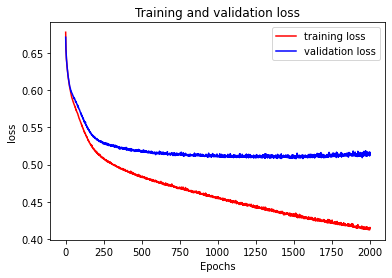

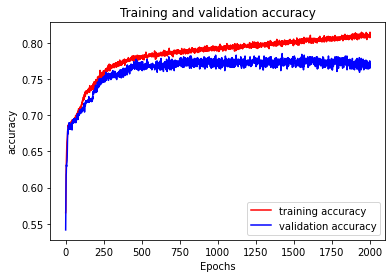

In [ ]:
import matplotlib.pyplot as plt

avg_acc= [ np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)]
avg_loss= [ np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)]
avg_val_acc= [ np.mean([x[i] for x in val_acc_histories]) for i in range(num_epochs)]
avg_val_loss= [ np.mean([x[i] for x in val_loss_histories]) for i in range(num_epochs)]


epochs = range(1,num_epochs+1)

plt.plot(epochs, avg_loss, 'r', label ='training loss')
plt.plot( epochs, avg_val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs, avg_acc, 'r', label ='training accuracy')
plt.plot(epochs, avg_val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



The below is a simple training technique on the entire training dataset

In [ ]:
model =build_model()
t_data = np.transpose(train_data[0:6])
num_epochs=2000
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(t_data, train_data[6], epochs=num_epochs,batch_size=32, verbose=0)



dict_keys(['loss', 'accuracy'])


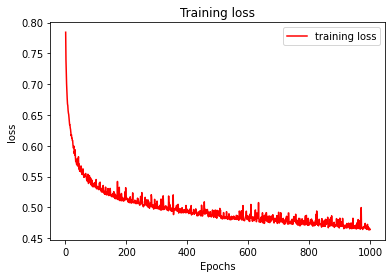

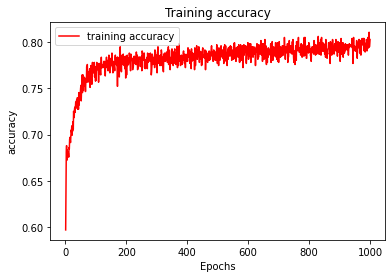

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

epochs = range(1,num_epochs+1)
loss = history.history['loss']
acc=history.history['accuracy']

plt.plot(epochs, loss, 'r', label ='training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'r', label ='training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

###The below adds some over/under fitting techniques to the model. Namely weight regularization and dropout.

l2(0.001) means every coefficient in the weights matrix will add 0.001*weight_coefficient_value to the total loss of the network. This penalty is only added at training time, the loss of the network will be much higher in training time than in test time. 

In [ ]:
# Building the network

from keras import models, layers, regularizers
def build_model():
  model =models.Sequential()
  model.add(layers.Dense(128, kernel_regularizer= regularizers.l2(0.001), activation ='relu', input_shape = (train_data.shape[0]-1,)  ))
  model.add(layers.Dense(64, kernel_regularizer= regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(16, kernel_regularizer= regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))  # Final layer is a prediction of a single value. Lets network able to predict any value rather than constraining it
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary
  return model



  

In [ ]:
model =build_model()
t_data = np.transpose(train_data[0:6])
num_epochs=100000
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0005)
history = model.fit(t_data, train_data[6], epochs=num_epochs,batch_size=32, verbose=0)



In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

epochs = range(1,num_epochs+1)
loss = history.history['loss']
acc=history.history['accuracy']

plt.plot(epochs, loss, 'r', label ='training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'r', label ='training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()